In [1]:
# Dokument for at udregne effekten af Danmarks tests
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 50)


import matplotlib.pyplot as plt
#%matplotlib widget
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams["image.cmap"] = "tab10"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fs_label = 16
parameters = {
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.markersize': 10,
                'lines.linewidth': 3
             }
plt.rcParams.update(parameters)
#%matplotlib widget
import matplotlib.colors as colors
from matplotlib import cm # Colormaps

cmap = cm.get_cmap('Dark2',7)

import locale
import matplotlib.dates as mdates
#locale.setlocale(locale.LC_TIME,"Danish")

import os
import math

from datetime import date


saveFigures = True
print('saveFigures is set to: '+str(saveFigures))
print('Done loading packages')

def rnMean(data,meanWidth):
    return np.convolve(data, np.ones(meanWidth)/meanWidth, mode='valid')
def rnTime(t,meanWidth):
    return t[math.floor(meanWidth/2):-math.ceil(meanWidth/2)+1]
def rnTime2(t,meanWidth):
    return t[meanWidth-1:]


saveFigures is set to: True
Done loading packages


In [2]:
ssidatapath = "ssi_data"
rootdir = os.getcwd() +"/" + ssidatapath


for subdir, dirs, files in os.walk(rootdir):
    if not len(files) == 0:
        latestdir = subdir
        latestDate = pd.to_datetime(subdir[-10:])

print(latestdir)
print(latestDate)

latestdir = rootdir+ '/SSI_data_2021-07-01'
latestDate = pd.to_datetime(latestdir[-10:])

# print(latestdir)
# print(latestDate)

/home/berrig/Documents/PandemiX/DanskeData/ssi_data/SSI_data_2021-02-12
2021-02-12 00:00:00


# Load datafiler

In [3]:
# Load the data
fulldfPCR = pd.read_csv(latestdir+'/Test_pos_over_time.csv',delimiter = ';',dtype=str)
fulldfAG = pd.read_csv(latestdir+'/Test_pos_over_time_antigen.csv',delimiter = ';',dtype=str)
dfAG2 = pd.read_csv(latestdir+'/Antigentests_pr_dag.csv',delimiter = ';')

# Cut out the last two rows of summary numbers
dfPCR = fulldfPCR.iloc[:-2,:].copy()
dfAG = fulldfAG.iloc[:-2,:].copy()

# Format columns correctly
dfPCR["PosPct"] = pd.to_numeric(dfPCR["PosPct"].astype(str).apply(lambda x: x.replace(',','.')))
dfPCR["Date"] = dfPCR["Date"].astype('datetime64[D]')
dfAG["PosPct"] = pd.to_numeric(dfAG["PosPct"].astype(str).apply(lambda x: x.replace(',','.')))
dfAG["Date"] = dfAG["Date"].astype('datetime64[D]')

rows_to_fix_period_in = ["NewPositive","NotPrevPos","PrevPos","Tested","Tested_kumulativ"]
for name in rows_to_fix_period_in:
    dfAG[name] = pd.to_numeric(dfAG[name].astype(str).apply(lambda x: x.replace('.','')))
    dfPCR[name] = pd.to_numeric(dfPCR[name].astype(str).apply(lambda x: x.replace('.','')))

dfAG2["Dato"] = dfAG2["Dato"].astype('datetime64[D]')
dfAG2["Andel_AGpos_PCRkonf_pct"] = pd.to_numeric(dfAG2["Andel_AGpos_PCRkonf_pct"].astype(str).apply(lambda x: x.replace(',','.')))
dfAG2["Andel_AGminusPCRkonf_pct"] = pd.to_numeric(dfAG2["Andel_AGminusPCRkonf_pct"].astype(str).apply(lambda x: x.replace(',','.')))

# Cut off early data in PCR dataframe
dfPCR = dfPCR[dfPCR.Date >= dfAG.iloc[0].Date]

# Also cutoff everything before first of January
firstDate = np.datetime64('2021-02-01')
dfPCR = dfPCR[dfPCR.Date >= firstDate]
dfAG = dfAG[dfAG.Date >= firstDate]

# Cut off last date (since it is not fully done)
dfPCR = dfPCR.iloc[:-1]
dfAG = dfAG.iloc[:-1]

# Get dates
curDates = dfPCR.Date.values.astype('datetime64[D]')
confDates = dfAG2.Dato.values.astype('datetime64[D]')

In [4]:
firstDate = np.datetime64('2021-02-01')
lastDate = curDates[-1]
lastDate

numpy.datetime64('2021-06-29')

# Metode 1

In [5]:
# Beregninger
PCRpos = dfPCR.NewPositive.values
numPCR = dfPCR.Tested.values
AGpos = dfAG.NewPositive.values
numAG = dfAG.Tested.values
AGposPCRpos = dfAG2.AGpos_PCRpos.values

PCRposPct = np.divide(PCRpos,numPCR)
AGposPct = np.divide(AGpos,numAG)

# Calculate the true positive rate
AGtruePos = np.divide(dfAG2.AGpos_PCRpos,dfAG2.AG_pos)
avgTruePos = AGtruePos.iloc[-14:].mean()
avgConf = 0.01*dfAG2['Andel_AGpos_PCRkonf_pct'].iloc[-14:].mean()

# Projectér hvor mange der bekræftes i de to dage der endnu ikke er bekræftet
# AGproj = np.divide(avgTruePos*dfAG2['AG_pos'],0.01*dfAG2['Andel_AGpos_PCRkonf_pct'].values)
AGproj = np.divide(avgTruePos*AGpos,avgConf)
confDatesProj = np.concatenate([confDates[:],curDates[-2:]])
confDatesProj = np.append(confDates[:],curDates[-2:]).astype('datetime64[D]')
AGposPCRposProj = np.append(AGposPCRpos,AGproj[-2:])
# 
PCRpos_nonAG = PCRpos - AGposPCRposProj

# 
PCRnoscreen = PCRpos_nonAG * ( (30000/dfPCR.Tested)**0.7)
PCRscreen = PCRpos_nonAG - PCRnoscreen

# Bredde af rullende gennemsnit
meanWidth = 7


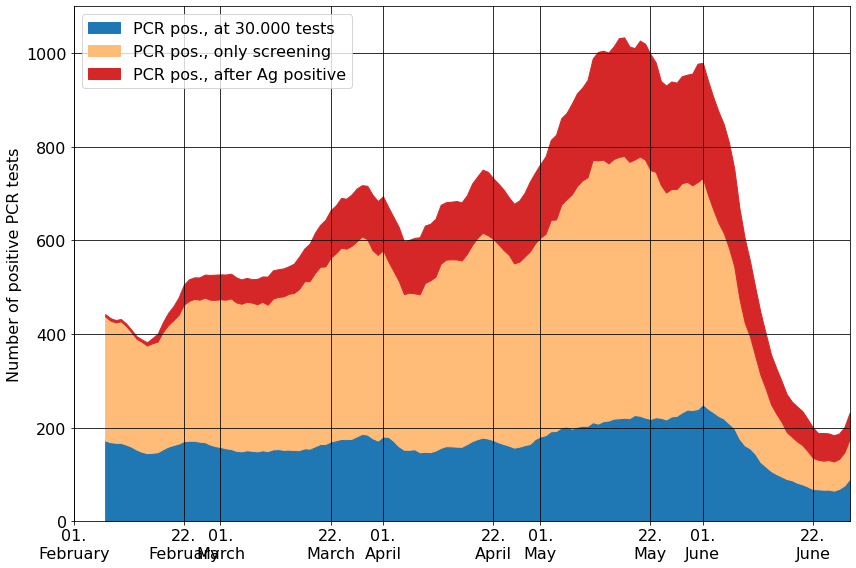

In [6]:
fig,ax1 = plt.subplots(1,1,sharex=True)


cmap = plt.cm.get_cmap('tab20',7)

ax1.fill_between(rnTime2(curDates,meanWidth),rnMean(PCRnoscreen,meanWidth),color=cmap(0),label='PCR pos., at 30.000 tests')
ax1.fill_between(rnTime2(curDates,meanWidth),rnMean(PCRpos_nonAG,meanWidth),rnMean(PCRnoscreen,meanWidth),color=cmap(1),label='PCR pos., only screening')

ax1.fill_between(rnTime2(curDates,meanWidth),rnMean(PCRpos,meanWidth),rnMean(PCRpos_nonAG,meanWidth),color=cmap(2),label='PCR pos., after Ag positive') 

# ax1.plot(curDates,PCRpos,'k.:',markersize=4,linewidth=0.5)

ax1.legend(loc='upper left')
ax1.grid(color='k')
# ax1.set_ylim(bottom=0)
ax1.set_ylim(bottom=0,top=1100)
ax1.set_ylabel('Number of positive PCR tests')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d.\n%B'))

curLastDate = rnTime2(curDates,meanWidth)[-1]
ax1.set_xlim([firstDate,curLastDate])
plt.tight_layout()

if saveFigures:
    plt.savefig('figs/Screening_PCRstacked')
    plt.savefig('/home/berrig/Documents/conferences/Epidemics8/presentation/figs/Screening_PCRstacked')
        

# Metode 2

In [7]:
AGpospct2 = np.divide(dfAG2['AGpos_PCRpos'],dfAG2['AG_testede'])
AGpospct2Mean = AGpospct2.values[-14:].mean()
AGpospct2 = np.append(AGpospct2,AGpospct2Mean)
AGpospct2 = np.append(AGpospct2,AGpospct2Mean)

AGsens = np.divide(dfAG2['AGpos_PCRpos'], dfAG2['AGpos_PCRpos'] + dfAG2['AGnegPCRpos'])
AGsensmean = AGsens.values[-14:].mean()
AGsens = np.append(AGsens,AGsensmean)
AGsens = np.append(AGsens,AGsensmean)

pcrScreenSimple = dfPCR.Tested - 30000

hardCodedSens = 0.618
hardCodedSens = 0.492
curEstimate = np.multiply(pcrScreenSimple.values,np.divide(AGpospct2,hardCodedSens))


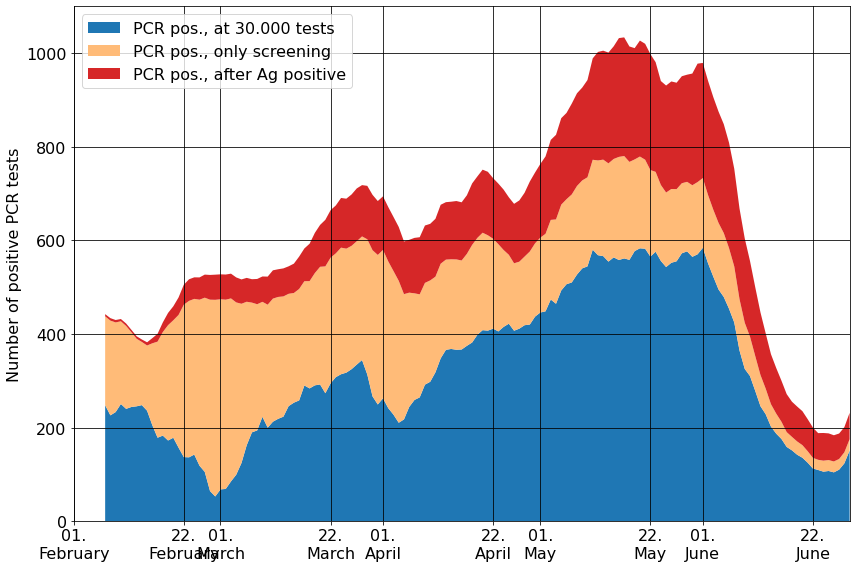

In [8]:
fig,ax1 = plt.subplots()




meanDays = rnTime2(curDates,meanWidth)


ax1.stackplot(meanDays,
    rnMean(PCRpos-AGposPCRposProj - curEstimate,meanWidth),
    rnMean(curEstimate,meanWidth),
    rnMean(AGposPCRposProj,meanWidth),
    labels=['PCR pos., at 30.000 tests','PCR pos., only screening','PCR pos., after Ag positive'],
    colors=[cmap(0),cmap(1),cmap(2)]
    )

ax1.legend(loc='upper left')
ax1.grid(color='k')
# ax1.set_ylim(bottom=0,top=7000)
ax1.set_ylim(bottom=0) 
ax1.set_ylim(bottom=0,top=1100)
ax1.set_ylabel('Number of positive PCR tests')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d.\n%B'))

curLastDate = rnTime2(curDates,meanWidth)[-1]
#firstDate = np.datetime64('2021-03-01')
ax1.set_xlim([firstDate,curLastDate])
plt.tight_layout()

if saveFigures:
    plt.savefig('figs/Screening_Metode2')
    plt.savefig('/home/berrig/Documents/conferences/Epidemics8/presentation/figs/Screening_Metode2')


# Sammenholdt med hinanden

In [9]:
print(f'400 / 1500 = {100 * 400 / 1500:2.1f} % ')
print(f'400 / 2833 = {100 * 400 / 2833:2.1f} % ')
print(f'800 / 1500 = {100 * 800 / 1500:2.1f} % ')
print(f'800 / 2833 = {100 * 800 / 2833:2.1f} % ')
print((1500+2833)/2)
print(f'600 / 2167 = {100 * 600 / 2167:2.1f} % ')

400 / 1500 = 26.7 % 
400 / 2833 = 14.1 % 
800 / 1500 = 53.3 % 
800 / 2833 = 28.2 % 
2166.5
600 / 2167 = 27.7 % 


In [10]:
print(f'400 / 1500 = {100 * 400 / 1500:2.1f} % ')
print(f'400 / 3000 = {100 * 400 / 3000:2.1f} % ')
print(f'800 / 1500 = {100 * 800 / 1500:2.1f} % ')
print(f'800 / 3000 = {100 * 800 / 3000:2.1f} % ')
print(f'600 / 2250 = {100 * 600 / 2250:2.1f} % ')

400 / 1500 = 26.7 % 
400 / 3000 = 13.3 % 
800 / 1500 = 53.3 % 
800 / 3000 = 26.7 % 
600 / 2250 = 26.7 % 


In [11]:
print(f'450 / 1500 = {100 * 450 / 1500:2.1f} % ')
print(f'450 / 3000 = {100 * 450 / 3000:2.1f} % ')
print(f'800 / 1500 = {100 * 800 / 1500:2.1f} % ')
print(f'800 / 3000 = {100 * 800 / 3000:2.1f} % ')
print(f'575 / 2250 = {100 * 575 / 2250:2.1f} % ')

450 / 1500 = 30.0 % 
450 / 3000 = 15.0 % 
800 / 1500 = 53.3 % 
800 / 3000 = 26.7 % 
575 / 2250 = 25.6 % 


# Andre plots

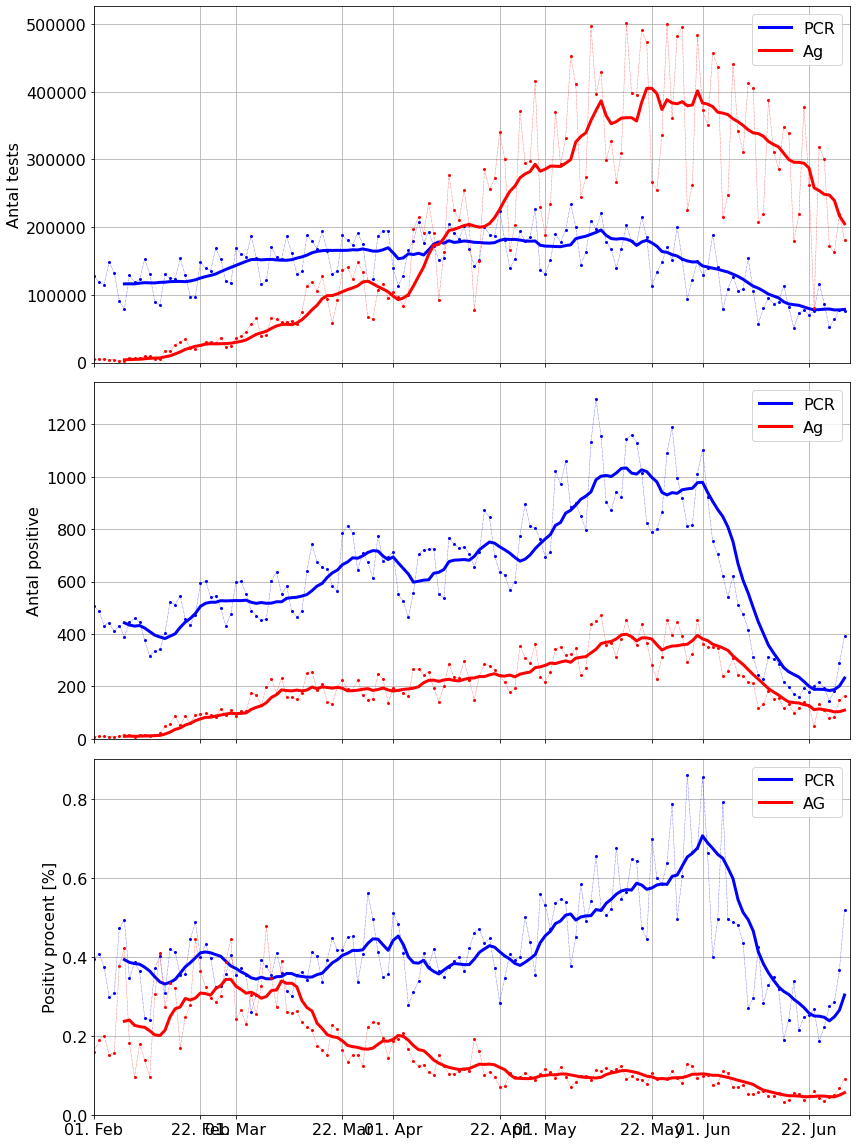

In [12]:
# Overblik over antal tests og antal positive

# fig,ax1 = plt.subplots(1,1)
# fig,(ax1,ax2) = plt.subplots(2,1)
fig,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(12,16))

PCRpos = dfPCR.NewPositive
AGpos = dfAG.NewPositive
PCRtest = dfPCR.Tested
AGtest = dfAG.Tested
ax1.plot(curDates,PCRtest,'b.:',markersize=4,linewidth=0.5)
ax1.plot(rnTime2(curDates,meanWidth),rnMean(PCRtest,meanWidth),'b',label='PCR')
ax1.plot(curDates,AGtest,'r.:',markersize=4,linewidth=0.5)
ax1.plot(rnTime2(curDates,meanWidth),rnMean(AGtest,meanWidth),'r',label='Ag')

ax2.plot(curDates,PCRpos,'b.:',markersize=4,linewidth=0.5)
ax2.plot(rnTime2(curDates,meanWidth),rnMean(PCRpos,meanWidth),'b',label='PCR')
ax2.plot(curDates,AGpos,'r.:',markersize=4,linewidth=0.5)
ax2.plot(rnTime2(curDates,meanWidth),rnMean(AGpos,meanWidth),'r',label='Ag')

ax3.plot(curDates,100 * np.divide(PCRpos,PCRtest),'b.:',markersize=4,linewidth=0.5)
ax3.plot(rnTime2(curDates,meanWidth),rnMean(100 * np.divide(PCRpos,PCRtest),meanWidth),'b',label='PCR')
ax3.plot(curDates,100 * np.divide(AGpos,AGtest),'r.:',markersize=4,linewidth=0.5)
ax3.plot(rnTime2(curDates,meanWidth),rnMean(100 * np.divide(AGpos,AGtest),meanWidth),'r',label='AG')


ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d. %b'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d. %b'))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d. %b'))

ax1.set_ylabel('Antal tests')
ax2.set_ylabel('Antal positive')
ax3.set_ylabel('Positiv procent [%]')


ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax3.set_ylim(bottom=0)

ax1.legend()
ax2.legend()
ax3.legend()
# ax1.legend(loc='center left',bbox_to_anchor = (1.0, 0.5))

ax1.grid()
ax2.grid()
ax3.grid()

ax1.set_xlim([firstDate,lastDate+np.timedelta64(1,'D')])
# ax1.set_xlim([np.datetime64('2021-04-01'),lastDate])
# ax1.set_xlim([firstDate,np.datetime64('2021-06-25')])

plt.tight_layout()
if saveFigures:
    plt.savefig('figs/Test_SimpleTal')

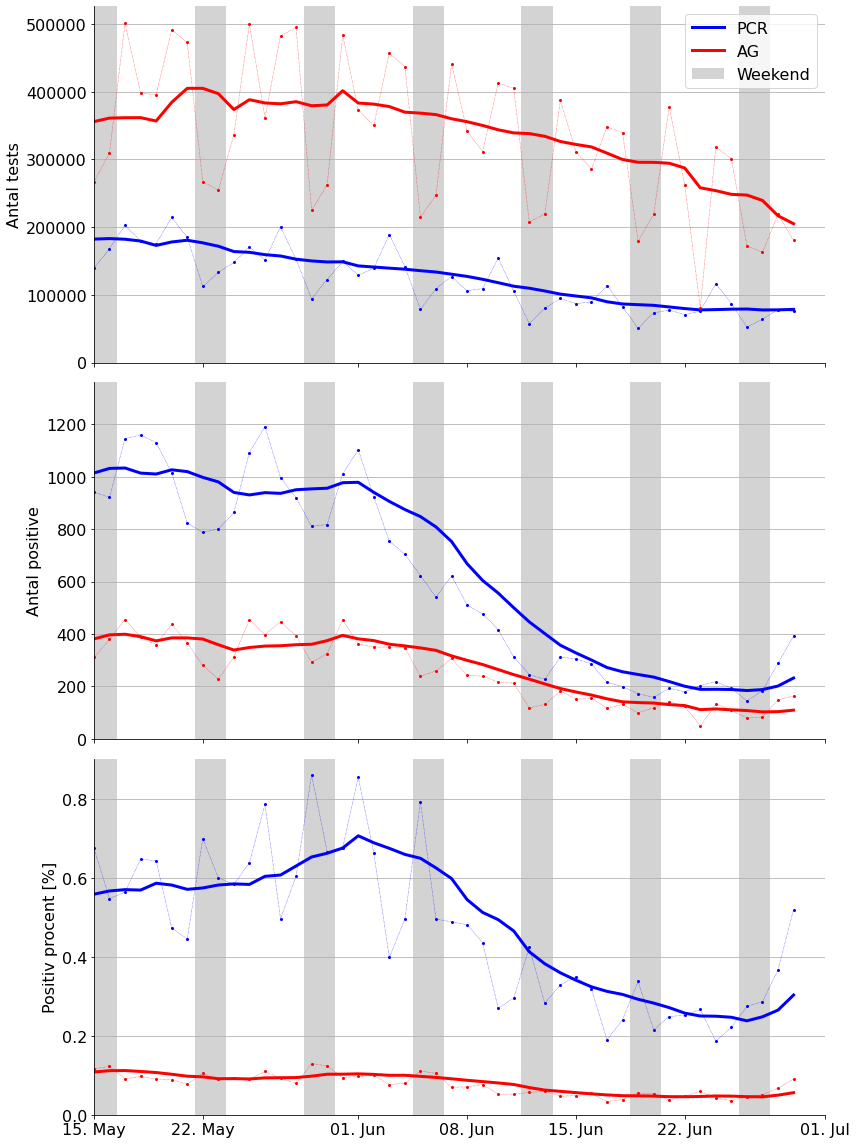

In [13]:
# Overblik over antal tests og antal positive

# fig,ax1 = plt.subplots(1,1)
# fig,(ax1,ax2) = plt.subplots(2,1)
fig,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(12,16))

PCRpos = dfPCR.NewPositive
AGpos = dfAG.NewPositive
PCRtest = dfPCR.Tested
AGtest = dfAG.Tested
ax1.plot(curDates,PCRtest,'b.:',markersize=4,linewidth=0.5)
ax1.plot(rnTime2(curDates,meanWidth),rnMean(PCRtest,meanWidth),'b',label='PCR')
ax1.plot(curDates,AGtest,'r.:',markersize=4,linewidth=0.5)
ax1.plot(rnTime2(curDates,meanWidth),rnMean(AGtest,meanWidth),'r',label='AG')

ax2.plot(curDates,PCRpos,'b.:',markersize=4,linewidth=0.5)
ax2.plot(rnTime2(curDates,meanWidth),rnMean(PCRpos,meanWidth),'b',label='PCR')
ax2.plot(curDates,AGpos,'r.:',markersize=4,linewidth=0.5)
ax2.plot(rnTime2(curDates,meanWidth),rnMean(AGpos,meanWidth),'r',label='AG')

ax3.plot(curDates,100 * np.divide(PCRpos,PCRtest),'b.:',markersize=4,linewidth=0.5)
ax3.plot(rnTime2(curDates,meanWidth),rnMean(100 * np.divide(PCRpos,PCRtest),meanWidth),'b',label='PCR')
ax3.plot(curDates,100 * np.divide(AGpos,AGtest),'r.:',markersize=4,linewidth=0.5)
ax3.plot(rnTime2(curDates,meanWidth),rnMean(100 * np.divide(AGpos,AGtest),meanWidth),'r',label='AG')


ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d. %b'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d. %b'))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d. %b'))

ax1.set_ylabel('Antal tests')
ax2.set_ylabel('Antal positive')
ax3.set_ylabel('Positiv procent [%]')

ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)

ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax3.set_ylim(bottom=0)

# Draw weekends
firstSunday = np.datetime64('2021-01-03')

numWeeks = 52

# curYlim = ax1.get_ylim()
# ax1.vlines([np.datetime64('2021-06-24'),np.datetime64('2021-06-25')],curYlim[0],curYlim[1])
for k in range(0,numWeeks):
    curSunday = firstSunday + np.timedelta64(7*k,'D')
    ax1.axvspan(curSunday-np.timedelta64(1,'D')-np.timedelta64(12,'h'),curSunday+np.timedelta64(12,'h'),facecolor='lightgrey')
    ax2.axvspan(curSunday-np.timedelta64(1,'D')-np.timedelta64(12,'h'),curSunday+np.timedelta64(12,'h'),facecolor='lightgrey')
    ax3.axvspan(curSunday-np.timedelta64(1,'D')-np.timedelta64(12,'h'),curSunday+np.timedelta64(12,'h'),facecolor='lightgrey')

ax1.axvspan(curSunday-np.timedelta64(1,'D')-np.timedelta64(12,'h'),curSunday+np.timedelta64(12,'h'),facecolor='lightgrey',label='Weekend')

ax1.legend()
# ax2.legend()
# ax3.legend()
# ax1.legend(loc='center left',bbox_to_anchor = (1.0, 0.5))

ax1.grid(axis='y')
ax2.grid(axis='y')
ax3.grid(axis='y')

firstDateToShow = np.datetime64('2021-05-15')
# ax1.set_xlim([firstDate,lastDate+np.timedelta64(1,'D')])
ax1.set_xlim([firstDateToShow,lastDate+np.timedelta64(2,'D')])
# ax1.set_xlim([np.datetime64('2021-04-01'),lastDate])
# ax1.set_xlim([firstDate,np.datetime64('2021-06-25')])
 

plt.tight_layout()
if saveFigures:
    plt.savefig('figs/VigtigeDanskeTal')

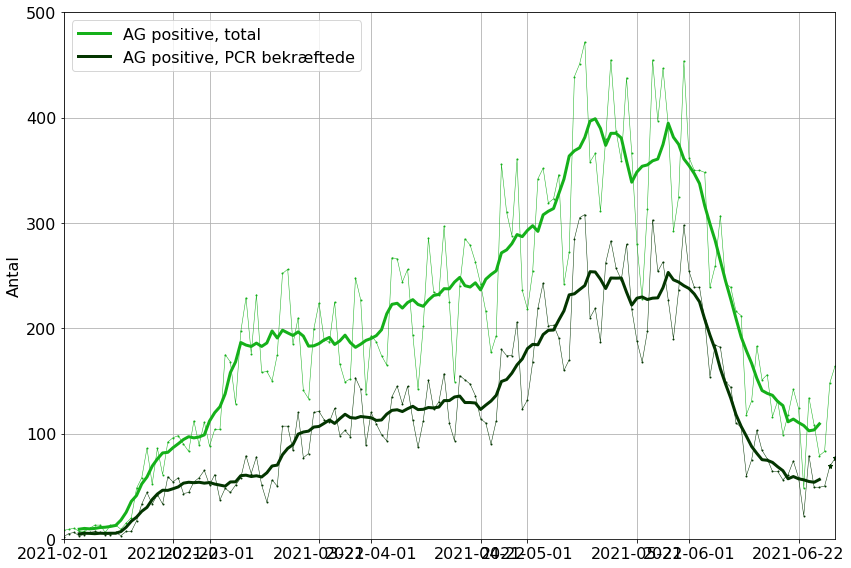

In [14]:
fig,ax1 = plt.subplots(1,1,sharex=True)

ax1.plot(curDates,AGpos,'.-',color='xkcd:green',linewidth=0.5,markersize=2)
ax1.plot(rnTime(curDates,meanWidth),rnMean(AGpos,meanWidth),color='xkcd:green',label='AG positive, total')

ax1.plot(confDatesProj,AGposPCRposProj,'.-',color='xkcd:dark green',linewidth=0.5,markersize=2)
ax1.plot(confDatesProj[-2:],AGposPCRposProj[-2:],'*',color='xkcd:dark green',markersize=5)
ax1.plot(rnTime(confDatesProj,meanWidth),rnMean(AGposPCRposProj,meanWidth),color='xkcd:dark green',label='AG positive, PCR bekræftede')


ax1.legend(loc='upper left')
ax1.grid()
ax1.set_ylim(bottom=0,top=500)
ax1.set_ylabel('Antal')

ax1.set_xlim([firstDate,lastDate])
plt.tight_layout()

if saveFigures:
    plt.savefig('figs/Screening_AGconfirmed')

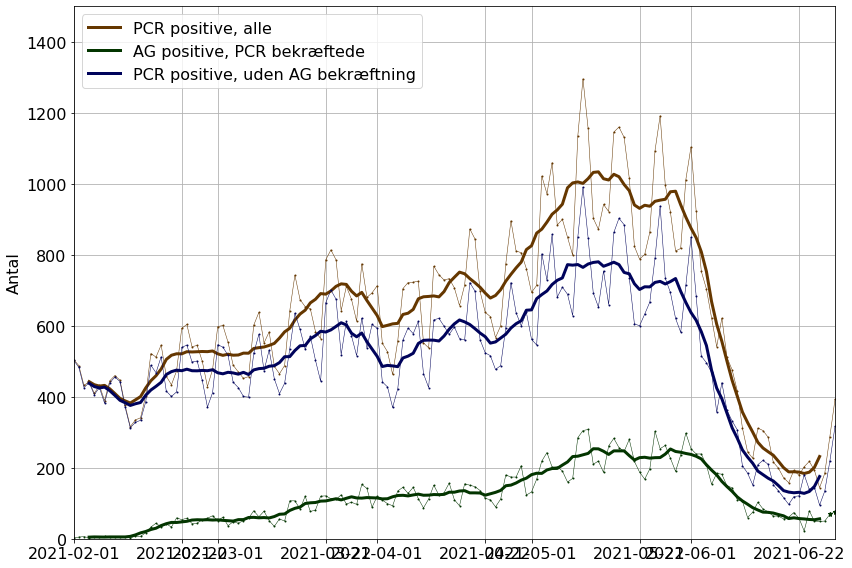

In [15]:
fig,ax1 = plt.subplots(1,1,sharex=True)

ax1.plot(curDates,PCRpos,'.-',color='xkcd:brown',linewidth=0.5,markersize=2)
ax1.plot(rnTime(curDates,meanWidth),rnMean(PCRpos,meanWidth),color='xkcd:brown',label='PCR positive, alle')

ax1.plot(curDates,AGposPCRposProj,'.-',color='xkcd:dark green',linewidth=0.5,markersize=2)
ax1.plot(curDates[-2:],AGposPCRposProj[-2:],'*',color='xkcd:dark green',markersize=5)
ax1.plot(rnTime(curDates,meanWidth),rnMean(AGposPCRposProj,meanWidth),color='xkcd:dark green',label='AG positive, PCR bekræftede')

ax1.plot(curDates,PCRpos_nonAG,'.-',color='xkcd:dark blue',linewidth=0.5,markersize=2)
ax1.plot(rnTime(curDates,meanWidth),rnMean(PCRpos_nonAG,meanWidth),color='xkcd:dark blue',label='PCR positive, uden AG bekræftning')

ax1.legend(loc='upper left')
ax1.grid()
ax1.set_ylim(bottom=0,top=1500)
ax1.set_ylabel('Antal')

ax1.set_xlim([firstDate,lastDate])
plt.tight_layout()

if saveFigures:
    plt.savefig('figs/Screening_PCRnonAG')

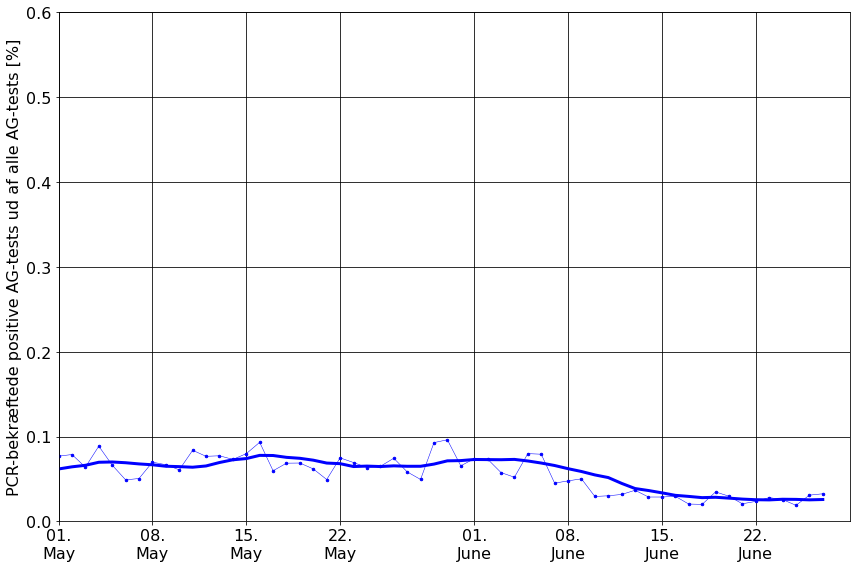

In [16]:
fig,ax1 = plt.subplots()

# ax1.plot(confDates,100 * np.divide(dfAG2['AGpos_PCRpos'],dfAG2['AG_testede']),'k.-',linewidth=0.5,markersize=4)
# ax1.plot(rnTime2(confDates,meanWidth),rnMean(100 * np.divide(dfAG2['AGpos_PCRpos'],dfAG2['AG_testede']),meanWidth),'k')

ax1.plot(confDates,np.divide(100 * np.divide(dfAG2['AGpos_PCRpos'],dfAG2['AG_testede']),0.01* dfAG2['Andel_AGpos_PCRkonf_pct']),'b.-',linewidth=0.5,markersize=5)
ax1.plot(rnTime2(confDates,meanWidth),rnMean(np.divide(100 * np.divide(dfAG2['AGpos_PCRpos'],dfAG2['AG_testede']),0.01* dfAG2['Andel_AGpos_PCRkonf_pct']),meanWidth),'b')
# dfAG2

# ax1.legend(loc='upper left')
ax1.grid(color='k')
# ax1.set_ylim(bottom=0,top=7000)
ax1.set_ylim(bottom=0,top = 0.6) 
# ax1.set_ylim(bottom=0,top = 0.2) 
# ax1.set_ylim(bottom=0,top = 0.1) 
ax1.set_ylabel('PCR-bekræftede positive AG-tests ud af alle AG-tests [%]')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d.\n%B'))

curLastDate = rnTime2(curDates,meanWidth)[-1]
firstDate = np.datetime64('2021-05-01')
ax1.set_xlim([firstDate,curLastDate])
plt.tight_layout()
if saveFigures:
    plt.savefig('figs/Screening_AGconf')